In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse

# Import data
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None

mnist = input_data.read_data_sets('./data/MNIST', one_hot=True)

Extracting ./data/MNIST/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/t10k-labels-idx1-ubyte.gz


//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


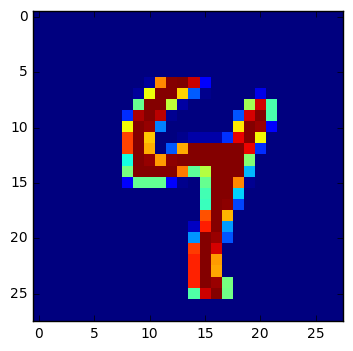

In [2]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = mnist.train.next_batch(5)
plt.imshow(np.reshape(images[2], (28, 28)), interpolation='nearest')
plt.show()


In [3]:
import random
import math
from scipy import ndimage, misc

digits = 5
hight = 28
width = 56
pixel_depth = 255.0

blank = np.zeros((28, 28))
blank_label = np.zeros((1, 11))
blank_label[0][10] = 1
blank_label = blank_label.flatten()


def concat_images(images):
    if images.shape[0] == 1:
        return np.reshape(images, (28, 28))
    return np.concatenate((np.reshape(images[0], (28,28)), concat_images(images[1:])), axis = 1)

def concat_labels(labels):
    if labels.shape[0] == 1:
        return labels
    return np.concatenate((labels[0], concat_labels(labels[1:])), axis = 1)

def decode_labels(labels):
    result = 0
    for i in range(labels.shape[0]):
        result *= 10
        result += np.ndarray.argmax(labels[i], axis = 0)
    return result

def gen_train_example():
    r = random.randint(1, digits)
    noOfBlanks = digits - r
    images, labels = mnist.train.next_batch(digits-noOfBlanks)
    result_image = concat_images(images)
    result_image = (misc.imresize(result_image, (hight, width)).astype(float) - pixel_depth / 2) / pixel_depth
    result_label = np.concatenate((labels, np.zeros((labels.shape[0], 1))), axis = 1)
    result_label = result_label.flatten()
    for _ in range(noOfBlanks):
        result_label = np.concatenate((blank_label, result_label), axis = 0)
    return result_image, result_label

def gen_train_examples(size):
    img = np.ndarray(shape=(size, hight, width))
    lbl = np.ndarray(shape=(size, 11*digits))
    for i in range(size):
        img[i], lbl[i] = gen_train_example()
    return img, lbl

def gen_test_example():
    r = random.randint(1, digits)
    noOfBlanks = digits - r
    images, labels = mnist.test.next_batch(digits-noOfBlanks)
    result_image = concat_images(images)
    result_image = (misc.imresize(result_image, (hight, width)).astype(float) - pixel_depth / 2) / pixel_depth
    result_label = np.concatenate((labels, np.zeros((labels.shape[0], 1))), axis = 1)
    result_label = result_label.flatten()
    for _ in range(noOfBlanks):
        result_label = np.concatenate((blank_label, result_label), axis = 0)
    return result_image, result_label

def gen_test_examples(size):
    img = np.ndarray(shape=(size, hight, width))
    lbl = np.ndarray(shape=(size, 11*digits))
    for i in range(size):
        img[i], lbl[i] = gen_test_example()
    return img, lbl


-0.3587510004


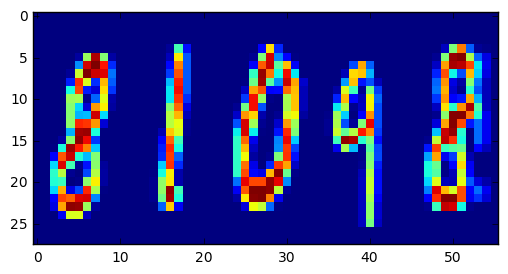

[8 1 0 9 8]


In [4]:
images, labels = gen_train_examples(1)
print (np.mean(images[0]))
plt.imshow(images[0], interpolation='nearest')
plt.show()
print (np.argmax(np.reshape(labels[0], (digits, 11)), 1))

In [5]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse

FLAGS = None

learning_rate = tf.placeholder(tf.float32, shape=[])

# Create the model
x = tf.placeholder(tf.float32, [None, hight, width]) 
x_image = tf.reshape(x, [-1, hight, width, 1])

keep_prob = tf.placeholder(tf.float32)

## First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 48])
b_conv1 = bias_variable([48])
  
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_lrn1 = tf.nn.lrn(h_pool1)
  
## Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 48, 128])
b_conv2 = bias_variable([128])

h_conv2 = tf.nn.relu(conv2d(h_lrn1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_lrn2 = tf.nn.lrn(h_pool2)

## Third Convolutional Layer
W_conv3 = weight_variable([5, 5, 128, 192])
b_conv3 = bias_variable([192])

h_conv3 = tf.nn.relu(conv2d(h_lrn2, W_conv3) + b_conv3)
h_lrn3 = tf.nn.lrn(h_conv3)

## Forth Convolutional Layer
W_conv4 = weight_variable([3, 3, 192, 192])
b_conv4 = bias_variable([192])

h_conv4 = tf.nn.relu(conv2d(h_lrn3, W_conv4) + b_conv4)
h_lrn4 = tf.nn.lrn(h_conv4)

## Densely Connected Layer 1
W_fc1 = weight_variable([hight * width * 12, 2048])
b_fc1 = bias_variable([2048])

h_pool2_flat = tf.reshape(h_lrn4, [-1, hight * width * 12])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Densely Connected Layer 2
W_fc2 = weight_variable([2048, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

## Readout Layer
W_fc3 = weight_variable([2048, 11*digits])
b_fc3 = bias_variable([11*digits])

y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
y_conv_r = tf.reshape(y_conv, [-1, digits, 11])

y = tf.placeholder(tf.float32, [None, 11*digits])
y_r = tf.reshape(y, [-1, digits, 11])

cross_entropy = tf.reduce_mean(  tf.nn.softmax_cross_entropy_with_logits(y_conv_r[0], y_r[0]) 
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[1], y_r[1])
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[2], y_r[2])
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[3], y_r[3])
                               + tf.nn.softmax_cross_entropy_with_logits(y_conv_r[4], y_r[4]))

train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

accuracy_list = list()
loss_list = list()

correct_prediction = tf.equal(tf.argmax(y_conv_r, 2), tf.argmax(y_r, 2))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy = tf.reduce_mean(tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1))
saver = tf.train.Saver()

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
no_of_steps = 1001
step = 100
for i in range(no_of_steps):
  batch_images, batch_labels = gen_train_examples(50)
  lr = 0.0005
  if i >= 4000:
    lr = 0.0002
  loss = train_step.run(feed_dict={x: batch_images, y: batch_labels, keep_prob: 1.0, learning_rate: lr})
  if i%step == 0:
    batch_images, batch_labels = gen_train_examples(500)
    loss, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={x:batch_images, y: batch_labels, keep_prob: 1.0, learning_rate: lr})
#    train_accuracy = accuracy.eval(feed_dict={x:batch_images, y_: batch_labels, keep_prob: 1.0})
    accuracy_list.append(train_accuracy)
    loss_list.append(loss)
    print("step %d, training accuracy %g, loss %g"%(i, train_accuracy, loss))
  
test_imgs, test_labels = gen_test_examples(2000)
print("test accuracy %g"%accuracy.eval(feed_dict={
  x: test_imgs, y: test_labels, keep_prob: 1.0}))

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x11468f990>> ignored


step 0, training accuracy 0, loss 377.154
step 100, training accuracy 0.008, loss 18.9013
step 200, training accuracy 0.036, loss 10.9165
step 300, training accuracy 0.074, loss 13.5823
step 400, training accuracy 0.062, loss 9.57307
step 500, training accuracy 0.05, loss 5.93258
step 600, training accuracy 0.078, loss 6.67105
step 700, training accuracy 0.1, loss 8.36311
step 800, training accuracy 0.126, loss 6.2505
step 900, training accuracy 0.094, loss 6.61645
step 1000, training accuracy 0.116, loss 5.06635
step 1100, training accuracy 0.194, loss 5.64256
step 1200, training accuracy 0.134, loss 6.10878
step 1300, training accuracy 0.17, loss 4.93205
step 1400, training accuracy 0.2, loss 4.29173
step 1500, training accuracy 0.236, loss 4.70104
step 1600, training accuracy 0.256, loss 2.78675
step 1700, training accuracy 0.222, loss 3.72618
step 1800, training accuracy 0.238, loss 7.449
step 1900, training accuracy 0.268, loss 3.92315
step 2000, training accuracy 0.28, loss 6.102

In [ ]:
import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(range(0, no_of_steps, step), accuracy_list, 'r')
plt.show()
fix.savefig('synth_lr0001.png')

In [ ]:
save_path = saver.save(sess, "./synth/model_synth.ckpt")
print("Model saved in file: %s" % save_path)

In [ ]:
test_imgs, test_labels = gen_test_examples(5000)
print("test accuracy %g"%accuracy.eval(feed_dict={
  x: test_imgs, y: test_labels, keep_prob: 1.0}))

In [ ]:
if False:
    sess = tf.InteractiveSession()
    saver.restore(sess, "./synth/model.ckpt")
    print ("Model restored.")

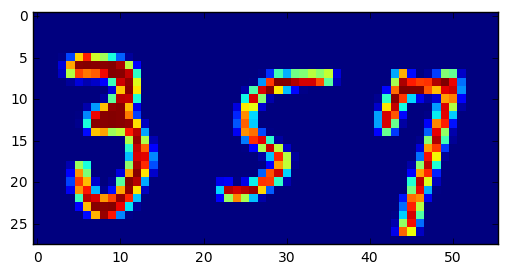

[[ 0.07862698  0.07862698  0.07862698  0.07862698  0.07862698  0.07862698
   0.07862698  0.07862698  0.07862698  0.07862698  0.21373029]
 [ 0.07862698  0.07862698  0.07862698  0.07862698  0.07862698  0.07862698
   0.07862698  0.07862698  0.07862698  0.07862698  0.21373029]
 [ 0.07862698  0.07862698  0.07862698  0.21373028  0.07862698  0.07862698
   0.07862698  0.07862698  0.07862698  0.07862698  0.07862698]
 [ 0.07862698  0.07862698  0.07862698  0.07862698  0.07862698  0.21373028
   0.07862698  0.07862698  0.07862698  0.07862698  0.07862698]
 [ 0.07862698  0.07862698  0.07862698  0.07862698  0.07862698  0.07862698
   0.07862698  0.21373028  0.07862698  0.07862698  0.07862698]]
0.000445995
Tensor("ArgMax_5:0", shape=(5,), dtype=int64)
[10 10  3  5  7]


In [30]:
test_imgs, test_labels = gen_train_examples(1)
plt.imshow(test_imgs[0], interpolation='nearest')
plt.show()

loss, train_accuracy, pred = sess.run([cross_entropy, accuracy, y], feed_dict={x:test_imgs, y:test_labels, keep_prob: 1.0, learning_rate: 1.0e-04})
# print (pred)
pred = tf.reshape(pred, (digits, 11))
pred = tf.nn.softmax(pred)
aa = pred.eval()
print (aa)
confidence = reduce(lambda a, b: a*b, [aa[i][a] for i, a in enumerate(np.argmax(aa, 1))])
print (confidence)
aa = tf.argmax(aa, 1)
print (aa)
print (np.argmax(tf.reshape(test_labels, (digits, 11)).eval(), 1))